In [356]:
import pandas as pd

def downsample_df(df: pd.DataFrame, n_minutes: int = 5) -> pd.DataFrame:
    """
    Downsample a DataFrame based on time index by averaging over n-minute intervals.

    Args:
        df (pd.DataFrame): Input DataFrame with 'Date' as the index.
        n_minutes (int, optional): Number of minutes to resample. Defaults to 5.

    Returns:
        pd.DataFrame: Downsampled DataFrame with 'Date' as index.
    """
    
    if df.index.name != 'Date':
        raise ValueError("The DataFrame index should be named 'Date'.")

    df_downsampled = df.resample(f'{n_minutes}min').mean()

    return df_downsampled



In [269]:
df = pd.read_csv('data_clean.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

In [304]:
import pandas as pd

def upsample_dataframe(df: pd.DataFrame, output_file: str) -> pd.DataFrame:
    """
    Upsample a DataFrame from its current time frequency to 1-minute frequency with linear interpolation.

    Args:
        df (pd.DataFrame): Input DataFrame with a datetime index.
        output_file (str): Path where the upsampled CSV will be saved.

    Returns:
        pd.DataFrame: Upsampled DataFrame with 'Date' as index.
    """
    full_index = pd.date_range(start=df.index.min(),
                               end=df.index.max(),
                               freq='min')

    df_upsampled = df.reindex(full_index)
    df_upsampled = df_upsampled.interpolate(method='linear')

    df_upsampled_reset = df_upsampled.reset_index().rename(columns={'index': 'Date'})
    df_upsampled_reset.to_csv(output_file, index=False)

    df_upsampled_final = df_upsampled_reset.set_index('Date')

    # print(df_upsampled_final.head(10))

    return df_upsampled_final


In [251]:
df_upsampled = upsample_dataframe(df_downsampled, 'upsampled_file.csv')

                      Series1   Series2   Series3   Series4   Series5  \
Date                                                                    
2012-01-01 00:00:00  0.403768 -1.354055  2.013771  1.059627 -1.803735   
2012-01-01 00:01:00  0.378759 -1.401326  2.016198  1.063940 -1.489319   
2012-01-01 00:02:00  0.353751 -1.448597  2.018624  1.068252 -1.174903   
2012-01-01 00:03:00  0.328742 -1.495867  2.021051  1.072565 -0.860487   
2012-01-01 00:04:00  0.303734 -1.543138  2.023478  1.076878 -0.546071   
2012-01-01 00:05:00  0.278726 -1.590409  2.025904  1.081190 -0.231655   
2012-01-01 00:06:00  0.242043 -1.599944  1.979857  1.047665 -0.023642   
2012-01-01 00:07:00  0.205360 -1.609478  1.933810  1.014140  0.184371   
2012-01-01 00:08:00  0.168677 -1.619013  1.887762  0.980615  0.392384   
2012-01-01 00:09:00  0.131995 -1.628547  1.841715  0.947089  0.600397   

                      Series6  
Date                           
2012-01-01 00:00:00 -0.877699  
2012-01-01 00:01:00 -0.8897

In [223]:
def get_indices_entire_sequence(
    data: pd.DataFrame, 
    window_size: int, 
    step_size: int
    ) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            data (pd.DataFrame): Partitioned data set, e.g. training data
            
            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [375]:
import numpy as np
import pandas as pd
from typing import Tuple, List

def get_xgboost_x_y(
    indices: List[Tuple[int, int]], 
    data: pd.DataFrame,
    target_sequence_length: int,
    input_seq_len: int,
    target_col: str = "Series1"
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Args:
        indices: List of (start_idx, end_idx) positions at which data should be sliced
        data: Multivariate time series DataFrame with datetime index (columns = Series1, Series2, ...)
        target_sequence_length: The forecasting horizon (m)
        input_seq_len: The input window size (n)

    Returns:
        all_x: np.ndarray of shape (number of instances, input_seq_len * number_of_features)
        all_y: np.ndarray of shape (number of instances, target_sequence_length)
    """

    num_features = data.shape[1]  # Number of columns/series
    all_x, all_y = None, None

    for i, idx in enumerate(indices):
        data_instance = data.iloc[idx[0]:idx[1]].values  # (window_size, num_features)

        x = data_instance[0:input_seq_len, :]  # (input_seq_len, num_features)
        y = data[target_col].iloc[idx[0] + input_seq_len : idx[0] + input_seq_len + target_sequence_length].values
        
        assert x.shape == (input_seq_len, num_features), f"x shape {x.shape} != ({input_seq_len}, {num_features})"
        assert len(y) == target_sequence_length, f"y length {len(y)} != {target_sequence_length}"

        x_flat = x.flatten()  # Flatten into (input_seq_len * num_features,)
        
        if i == 0:
            all_x = x_flat.reshape(1, -1)
            all_y = y.reshape(1, -1)
        else:
            all_x = np.concatenate((all_x, x_flat.reshape(1, -1)), axis=0)
            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)


    return all_x, all_y

In [350]:

def generate_XY_train_XY_test(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    hyperparameters: dict, 
    target_sequence_length: int,
    series: str
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate training and test data for XGBoost model.

    Args:
        df (pd.DataFrame): Downsampled DataFrame with datetime index.
        hyperparameters (dict): Hyperparameters for the model.
        target_sequence_length (int): Length of the target sequence.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]: x_train, y_train, x_test, y_test
    """

    training_indices = get_indices_entire_sequence(
        data=train_df, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=hyperparameters["step_size"]
        )

    x_train, y_train = get_xgboost_x_y(
        indices=training_indices, 
        data=train_df[hyperparameters["selected_features"]],
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"],
        target_col=series
        )

    test_indices = get_indices_entire_sequence(
        data=test_df, 
        window_size=hyperparameters["in_length"]+target_sequence_length, 
        step_size=target_sequence_length
        )

    x_test, y_test = get_xgboost_x_y(
        indices=test_indices, 
        data=test_df[hyperparameters["selected_features"]],
        target_sequence_length=target_sequence_length,
        input_seq_len=hyperparameters["in_length"],
        target_col=series
        )
    
    return x_train, y_train, x_test, y_test


In [339]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

def train_xgboost_model(
    x_train: np.ndarray, 
    y_train: np.ndarray, 
    hyperparameters: dict
    ) -> MultiOutputRegressor:
    """
    Train an XGBoost model for multi-output regression.

    Args:
        x_train (np.ndarray): Training input data.
        y_train (np.ndarray): Training target data.
        hyperparameters (dict): Hyperparameters for the model.

    Returns:
        MultiOutputRegressor: Trained XGBoost model.
    """
    model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )
    
    trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

    
    return trained_model

In [380]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


def model_predict(
    model: MultiOutputRegressor, 
    x_test: np.ndarray, 
    y_test: np.ndarray,
    test_data: pd.DataFrame,
    ) -> Tuple[float, float, float]:
    """
    Evaluate the trained model on the test data.

    Args:
        model (MultiOutputRegressor): Trained XGBoost model.
        x_test (np.ndarray): Test input data.
        y_test (np.ndarray): Test target data.

    Returns:
        Tuple[float, float, float]: RMSE, MAE, and R2 score of the model on the test data.
    """
    test_forecasts = model.predict(x_test)
    test_forecasts = test_forecasts.flatten()

    if len(test_forecasts) <= len(test_data):
        test_data = test_data.iloc[:len(test_forecasts)]
    else:
        raise ValueError("Test forecasts and test data lengths do not match.")
        
    forecast_df = pd.DataFrame(
        {"Forecast": test_forecasts}, 
        index=test_data.index
    )

    forecast_df = upsample_dataframe(forecast_df, 'forecast_upsampled.csv')

    if len(forecast_df) < len(y_test):
        y_test = y_test[:len(forecast_df)]
    else:
        raise ValueError("Forecast and test data lengths do not match.")
    
    return forecast_df, y_test

def evaluate_model(
    forecast_df: pd.DataFrame,
    y_test: np.ndarray,
    ) -> Tuple[float, float, float]:
    test_mae = mean_absolute_error(y_test, forecast_df)
    test_mse = mean_squared_error(y_test, forecast_df)
    test_r2 = r2_score(y_test, forecast_df)
    test_rmse = np.sqrt(test_mse)
    
    return test_rmse, test_mae, test_r2




In [395]:
import matplotlib.pyplot as plt

def visualize_model(forecast_df: pd.DataFrame, y_test: np.ndarray) -> None:
    """
    Visualize the model's forecasts against the actual test data.

    Args:
        forecast_df (pd.DataFrame): DataFrame containing the model's forecasts.
        y_test (np.ndarray): Actual test data.

    Returns:
        None
    """

    fontsize = 16
    plot_df = pd.DataFrame({
        "Forecasts": forecast_df["Forecast"],
        "Targets": y_test
    }, index=forecast_df.index)

    fig = plt.figure(figsize=(20,12))
    plt.plot(plot_df.index, plot_df["Forecasts"], label="Forecasts")
    plt.plot(plot_df.index, plot_df["Targets"], label="Targets")

    plt.xlabel('Time', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel("Electricity price, EUR/MWh", fontsize=fontsize)
    plt.grid(True)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()



In [382]:
import itertools
from tqdm import tqdm

def generate_xgboost_model(
    df: pd.DataFrame, series: str, visualize: bool = False
) -> MultiOutputRegressor:

    df_downsampled = downsample_df(df, n_minutes=5)

    target_variables = [
        "Series1",
        "Series2",
        "Series3",
        "Series4",
        "Series5",
        "Series6",
    ]
    hyperparameters = {
        "in_length": [15],
        "step_size": [15],
        "n_estimators": [10, 20, 50],
        "max_depth": [4, 6, 8],
        "subsample": [0.5, 0.7, 1.0],
        "learning_rate": [0.01, 0.1, 0.2],
        "min_child_weight": [1, 2, 3],
        "selected_features": [target_variables],
    }
    
    target_sequence_length = 60 * 4 // 5
    first_day_test = "2013-07-01"

    training_data = df_downsampled[df_downsampled.index < first_day_test]

    test_data = df_downsampled[df_downsampled.index >= first_day_test]
    
    param_combinations = list(itertools.product(
        hyperparameters["in_length"],
        hyperparameters["step_size"],
        hyperparameters["n_estimators"],
        hyperparameters["max_depth"],
        hyperparameters["subsample"],
        hyperparameters["learning_rate"],
        hyperparameters["min_child_weight"],
        hyperparameters["selected_features"]
    ))
    
    param_combinations_df = pd.DataFrame(param_combinations, columns=hyperparameters.keys())
    best_model = None
    best_r2 = 0  # Initialize to a very high value
    for _, params_row in tqdm(param_combinations_df.iterrows(), total=param_combinations_df.shape[0], desc="Training Models"):
        params = params_row.to_dict()
        X_train, y_train, x_test, y_test = generate_XY_train_XY_test(
            train_df=training_data,
            test_df=test_data,
            hyperparameters=params,
            target_sequence_length=target_sequence_length,
            series=series,
        )

        model = train_xgboost_model(
            x_train=X_train,
            y_train=y_train,
            hyperparameters=params,
        )

        forecast_df, y_test = model_predict(
            model=model,
            x_test=x_test,
            y_test=df[series][df.index >= first_day_test].to_numpy(),
            test_data=test_data,
        )

        _, _, r2 = evaluate_model(
            forecast_df=forecast_df,
            y_test=y_test,
        )
        
        if r2 > best_r2:
            best_r2 = r2
            best_model = model  # Save the current best model
            print(f"New best model found with R2: {best_r2} - Hyperparameters: {params}")

    # if visualize:
        # visualize_model(forecast_df, y_test)

    return best_model

In [397]:
def apply_model(
    model: MultiOutputRegressor, df: pd.DataFrame, series: str
) -> pd.DataFrame:
    """
    Apply the trained model to the entire dataset.

    Args:
        model (MultiOutputRegressor): Trained XGBoost model.
        df (pd.DataFrame): DataFrame containing the data to be predicted.
        series (str): The target variable to be predicted.

    Returns:
        pd.DataFrame: DataFrame with predictions.
    """
    df_downsampled = downsample_df(df, n_minutes=5)

    target_sequence_length = 60 * 4 // 5

    test_indices = get_indices_entire_sequence(
        data=df_downsampled,
        window_size=15 + target_sequence_length,
        step_size=target_sequence_length,
    )

    x_test, y_test = get_xgboost_x_y(
        indices=test_indices,
        data=df_downsampled[
            [
                "Series1",
                "Series2",
                "Series3",
                "Series4",
                "Series5",
                "Series6",
            ]
        ],
        target_sequence_length=target_sequence_length,
        input_seq_len=15,
        target_col=series,
    )

    forecast_df, y_test = model_predict(
        model=model,
        x_test=x_test,
        y_test=df[series].to_numpy(),
        test_data=df_downsampled,
    )

    rmse, mae, r2 = evaluate_model(
        forecast_df=forecast_df,
        y_test=y_test,
    )
    
    print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

    visualize_model(forecast_df, y_test)

    return forecast_df

In [398]:
df = pd.read_csv('data_clean.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

best_model = generate_xgboost_model(df, "Series1", visualize=True)


Training Models:   0%|                                                                | 0/243 [00:05<?, ?it/s]


KeyboardInterrupt: 

RMSE: 0.36148954249587684, MAE: 0.2967518664293357, R2: 0.542183494758824


,Forecast
Date,
2013-10-02 00:00:00,-1.897050
2013-10-02 00:01:00,-1.896910
2013-10-02 00:02:00,-1.896770
2013-10-02 00:03:00,-1.896630
2013-10-02 00:04:00,-1.896491
...,...
2013-10-02 19:51:00,-0.851203
2013-10-02 19:52:00,-0.861516
2013-10-02 19:53:00,-0.871829


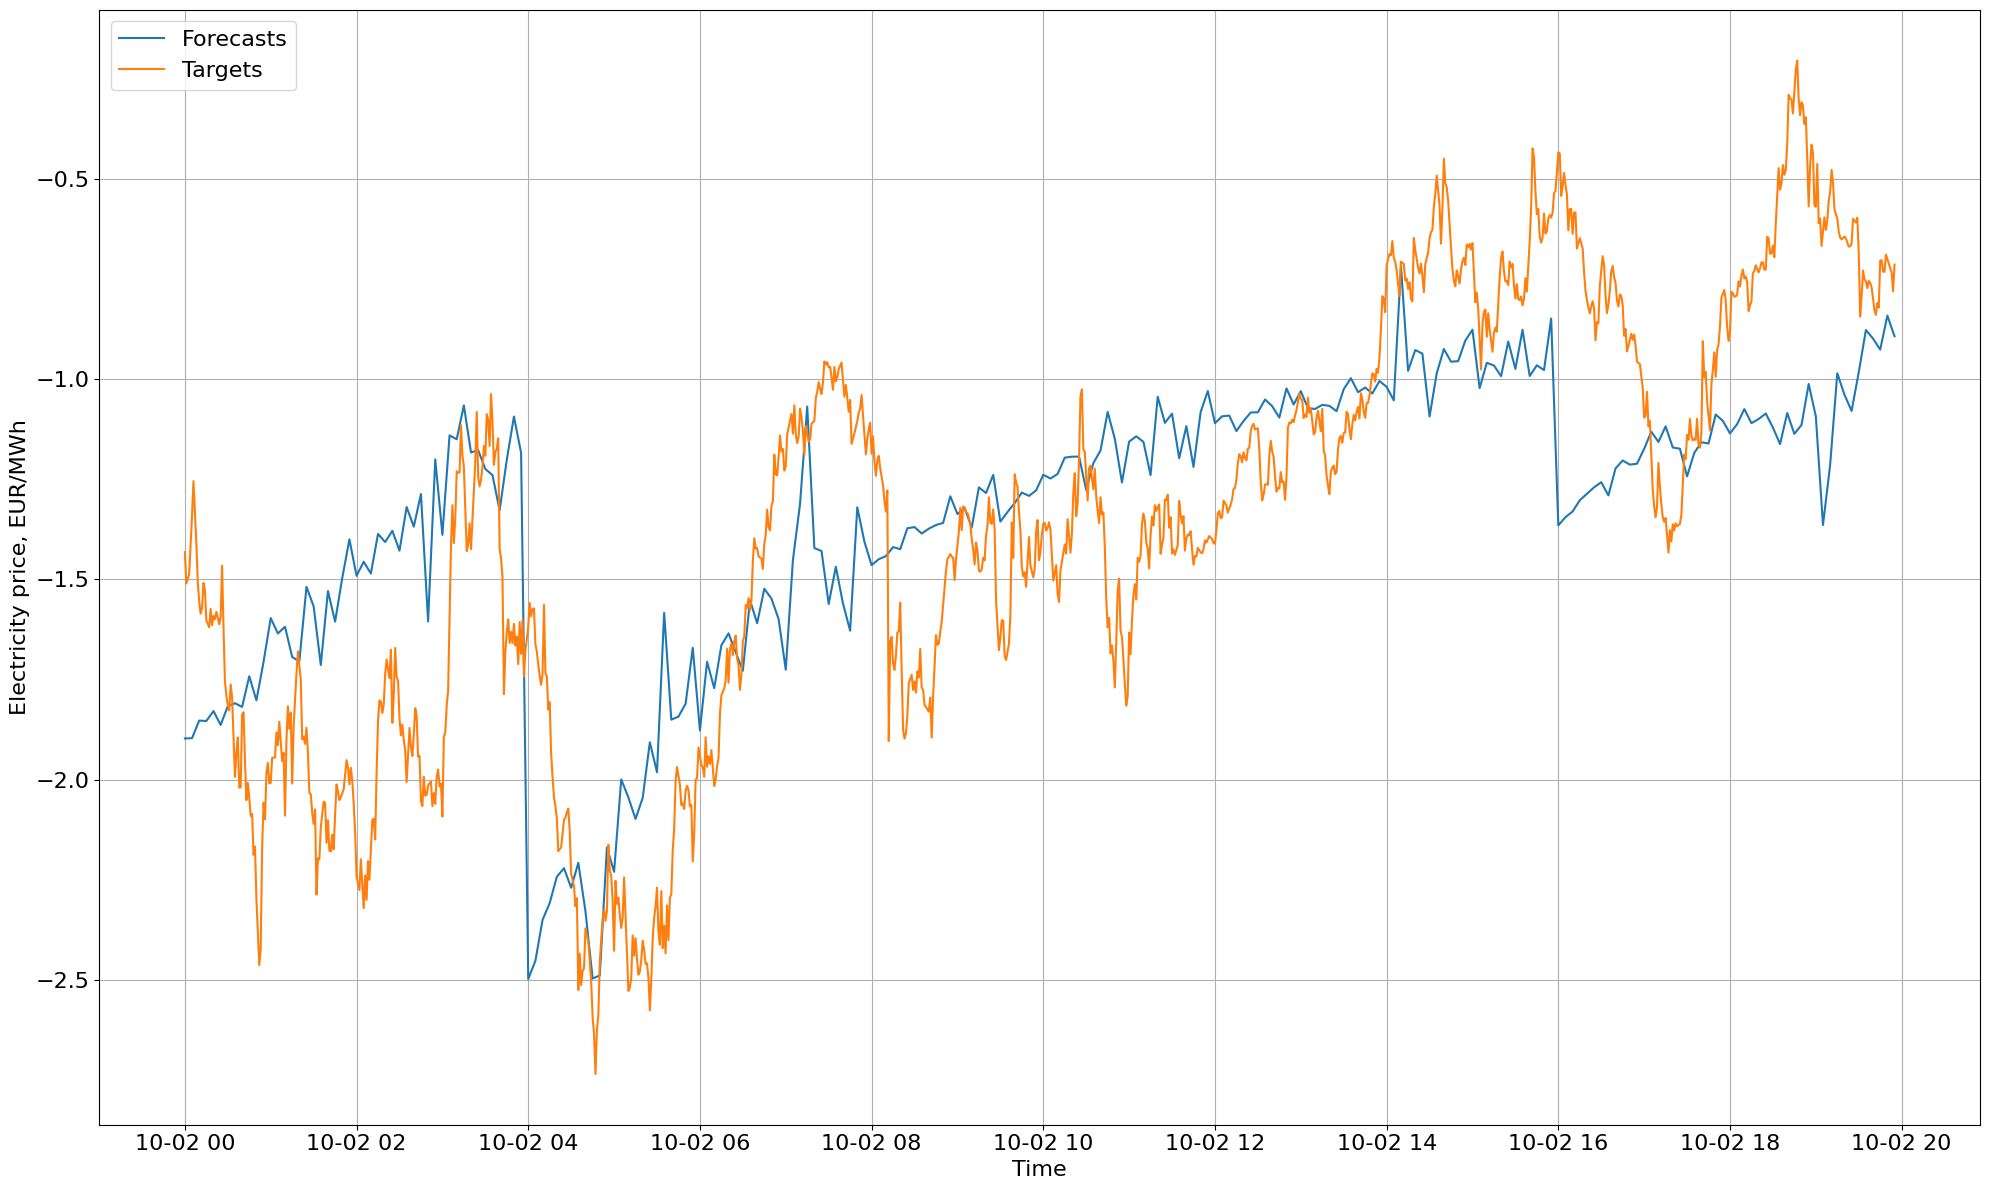

In [405]:
apply_model(best_model, df[(df.index >= "2013-10-02") & (df.index <= "2013-10-03")], "Series1")